# Хакатон МТУСИ 2020

## Участники: Власов Глеб, Щитов Владислав

In [43]:
import pyprind
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random

from collections import Counter 
from string import punctuation
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score, f1_score, precision_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Embedding, Dense, Dropout, Activation, LSTM, Conv1D, MaxPool1D, GRU
from tensorflow.keras.models import load_model, save_model

%matplotlib inline

### Загрузка датасетов

In [2]:
dga_test = pd.read_csv('dga_test', sep='\t')
dga_test.columns = ['domain', 'indexes']
dga_test.indexes = dga_test.indexes.apply(lambda x: x-(x-1))
dga_test.sample(5)

,domain,indexes
375,loxirpogirv.kz,1
1832,vudaupemo.ddns.net,1
1479,cdghkmcfihko.net,1
602,kyskuoumaogmuiyw.org,1
1951,sedoestnessbiophysicalohax.com,1


In [3]:
dga_train = pd.read_csv('dga_train', sep='\t')
dga_train.columns = ['domain', 'indexes']
dga_train.indexes = dga_train.indexes.apply(lambda x: x-(x-1))
dga_train.sample(5)

,domain,indexes
9161,lfbiers.info,1
11646,hnhwicb.in,1
3539,745x7jk6evgja0m87vu.ddns.net,1
1551,mkeguttudxxipkioi.net,1
13012,gwdxijyztw.com,1


In [4]:
legit_train = pd.read_csv('legit_train', sep='\t')
legit_train.columns = ['domain']
legit_train['indexes'] = 0
legit_train.sample(5)

,domain,indexes
2966,acoustica.com,0
6067,delta.app,0
7545,nbcsports.com,0
7794,easymanage.biz,0
8260,orgamix.vn,0


In [5]:
legit_test = pd.read_csv('legit_test', sep='\t')
legit_test.columns = ['domain']
legit_test['indexes'] = 0
legit_test.sample(5)
len(legit_test)

2999

### Обработка датасета

In [6]:
dga = pd.concat([dga_train, dga_test], ignore_index=True)
legit = pd.concat([legit_train, legit_test], ignore_index=True)
domains = pd.concat([legit_train, legit_test,
                    dga_train, dga_test], ignore_index=True)
X = domains.domain.tolist()
domains.head(10)

,domain,indexes
0,ademaltan.com.tr,0
1,ahedu.gov.cn,0
2,firstory.me,0
3,major-nissan.ru,0
4,torplay.ir,0
5,sudutnusantara.com,0
6,articlexpress.co.uk,0
7,kashmirfight.wordpress.com,0
8,crackedlink.com,0
9,traiborg.com,0


In [7]:
counts = Counter()
unique_symbols = enumerate(set(''.join(domains.domain.tolist())))

for i, symbol in unique_symbols:
    counts.update(symbol.split())

In [8]:
symbol_counts = sorted(counts, key=counts.get)
symbol_toint = {symbol: i for i, symbol in enumerate(symbol_counts, 1)}
# symbol_toint

In [9]:
mapped_domains = []

for domain in domains.domain:
    domain_int = []
    for char in domain:
        domain_int.append(symbol_toint[char])
    mapped_domains.append(domain_int)

In [10]:
type(mapped_domains)

list

In [11]:
X[0]

'ademaltan.com.tr'

In [12]:
sequence_length = np.max([len(domain) for domain in domains.domain])
sequences = np.zeros((len(mapped_domains), sequence_length), dtype=int)
sequences.shape

(28967, 53)

### Вариант 1:

In [13]:
for i, row in enumerate(mapped_domains):
    domain_arr = np.array(row)
    sequences[i, -len(row):] = domain_arr[-sequence_length:]
type(sequences)
sequences.shape

(28967, 53)

### Вариант 2: 

In [14]:
sequences2 = tf.keras.preprocessing.sequence.pad_sequences(
    mapped_domains, sequence_length)
sequences_val = np.hstack([np.zeros(len(dga_test)+len(dga_train)),
                          np.ones(len(legit_test)+len(legit_train))])
sequences_val
# domains

array([0., 0., 0., ..., 1., 1., 1.])

In [47]:
X_train, X_test, Y_train, Y_test = train_test_split(
    sequences, sequences_val, test_size=0.2, shuffle=True)

In [16]:
X_train.shape

(23173, 53)

In [17]:
def create_batch_generator(x, y=None, batch_size=64):
    n_batches = len(x)//batch_size
    x = x[:n_batches*batch_size]
    if y is not None:
        y = y[:n_batches*batch_size]

    for i in range(0, len(x), batch_size):
        if y is not None:
            yield x[i:i+batch_size], y[i:i+batch_size]
        else:
            yield x[i:i+batch_size]

### Параметры модели

In [18]:
n_classes = 2
n_features = len(counts) + 1
epoch = 25
batch_size = 16

In [19]:
cb = []
cb.append(EarlyStopping(monitor='val_loss', patience=5,
                        verbose=0, mode='auto', 
                        restore_best_weights=False, 
                        baseline=None))

cb_gru=[]
cb_gru.append(EarlyStopping(monitor='val_loss', min_delta=0, patience=3,
                        verbose=0, mode='auto', baseline=None,
                        restore_best_weights=False))
# cb_gru.append(tf.keras.callbacks.ModelCheckpoint('LSTM_try_v2/',
#                                             monitor='acc',
#                                             verbose=0,
#                                             save_best_only=True,
#                                             save_weights_only=False,
#                                             mode='max',
#                                             save_freq=1))

In [20]:
def build_gru(n_features, sequence_length):
    gru_model = tf.keras.models.Sequential()
    gru_model.add(Embedding(input_dim=n_features, output_dim=64, input_length=sequence_length))
    gru_model.add(Conv1D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu'))
    gru_model.add(MaxPool1D(pool_size=2, padding='same'))
    gru_model.add(GRU(units=64))
    gru_model.add(Dense(128, activation='tanh'))
    gru_model.add(Dense(1, activation='sigmoid'))
    
    gru_model.compile(loss='binary_crossentropy',
                      optimizer='rmsprop', metrics=['binary_crossentropy','acc'])
    return gru_model

In [21]:
gru_model = build_gru(n_features, sequence_length)
gru_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 53, 64)            4160      
_________________________________________________________________
conv1d (Conv1D)              (None, 53, 64)            12352     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 27, 64)            0         
_________________________________________________________________
gru (GRU)                    (None, 64)                24960     
_________________________________________________________________
dense (Dense)                (None, 128)               8320      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 49,921
Trainable params: 49,921
Non-trainable params: 0
____________________________________________________

In [23]:
# def gen_model(max_features, max_len):
#     model = tf.keras.models.Sequential()
#     model.add(Embedding(max_features, 64, input_length=max_len))
#     model.add(LSTM(64))
#     model.add(Dropout(0.5))
#     model.add(Dense(1))
#     model.add(Activation('sigmoid'))
    
#     model.compile(loss='binary_crossentropy', optimizer='rmsprop',
#                  metrics=['binary_crossentropy', 'acc'])
#     return model

In [24]:
# model = gen_model(n_features, sequence_length)
# model.summary()
# Y_train[:10]

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 53, 64)            4160      
_________________________________________________________________
lstm (LSTM)                  (None, 64)                33024     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
_________________________________________________________________
activation (Activation)      (None, 1)                 0         
Total params: 37,249
Trainable params: 37,249
Non-trainable params: 0
_________________________________________________________________


array([0., 0., 1., 1., 0., 1., 1., 1., 1., 0.])

In [40]:
# history = model.fit(X_train, Y_train, 
#                     batch_size=16, 
#                     epochs=epoch, 
#                     verbose=1, 
#                     callbacks=cb, 
#                     validation_split=0.2,
#                     validation_data=None, 
#                     shuffle=True, 
#                     class_weight=None, 
#                     sample_weight=None, 
#                     initial_epoch=0,
#                     steps_per_epoch=None, 
#                     validation_steps=None)

In [22]:
history = gru_model.fit(X_train, Y_train, batch_size=16,
                       validation_data=(X_test, Y_test),
                       epochs=epoch,
                       verbose=1, 
                    callbacks=cb_gru, 
                    shuffle=True, 
                    class_weight=None, 
                    sample_weight=None, 
                    initial_epoch=0) 

Epoch 1/25
1449/1449 [==============================] - 9s 6ms/step - loss: 0.4269 - binary_crossentropy: 0.4269 - acc: 0.8149 - val_loss: 0.3528 - val_binary_crossentropy: 0.3528 - val_acc: 0.8474
Epoch 2/25
1449/1449 [==============================] - 9s 6ms/step - loss: 0.3308 - binary_crossentropy: 0.3308 - acc: 0.8590 - val_loss: 0.3209 - val_binary_crossentropy: 0.3209 - val_acc: 0.8609
Epoch 3/25
1449/1449 [==============================] - 9s 6ms/step - loss: 0.2938 - binary_crossentropy: 0.2938 - acc: 0.8776 - val_loss: 0.3139 - val_binary_crossentropy: 0.3139 - val_acc: 0.8747
Epoch 4/25
1449/1449 [==============================] - 9s 6ms/step - loss: 0.2729 - binary_crossentropy: 0.2729 - acc: 0.8864 - val_loss: 0.2780 - val_binary_crossentropy: 0.2780 - val_acc: 0.8868
Epoch 5/25
1449/1449 [==============================] - 9s 6ms/step - loss: 0.2521 - binary_crossentropy: 0.2521 - acc: 0.8976 - val_loss: 0.2951 - val_binary_crossentropy: 0.2951 - val_acc: 0.8835
Epoch 6/25

In [33]:
gru_model.save('GRU_W')

INFO:tensorflow:Assets written to: GRU_W\assets


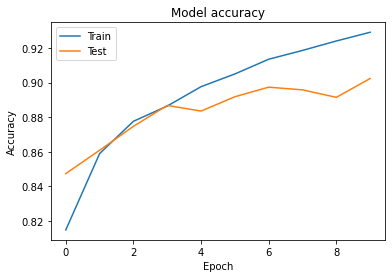

In [24]:
plt.plot(history.history['acc']) 
plt.plot(history.history['val_acc']) 
plt.title('Model accuracy') 
plt.ylabel('Accuracy') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Test'], loc='upper left') 
plt.show() 

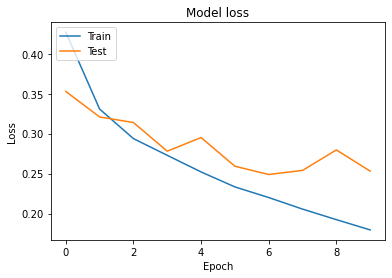

In [25]:
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Test'], loc='upper left') 
plt.show()

# Проверка

In [34]:
model = tf.keras.models.load_model('GRU_W')

#### Проверка на данных из train_test_split

In [35]:
result = {}
Y_predict_value = model.predict(X_test)
result['roc_auc_score'] = roc_auc_score(Y_test, Y_predict_value)
result

{'roc_auc_score': 0.963743694430368}

In [45]:
path_dga = #путь к файлу
path_legit = #путь к файлу
df_dga = pd.read_csv(path_dga, sep='\t')
df_legit = pd.read_csv(path_legit, sep='\t')
df_dga.columns = ['Domain', 'class']
df_legit.columns = ['Domain']
df_dga['class'] = 0
df_legit['class'] = 1
df = pd.concat([df_dga, df_legit], ignore_index=True)
symbols = {'n': 1, 'r': 2, 's': 3, 'R': 4, 'o': 5, '2': 6, 'N': 7, 'I': 8, 'h': 9, 'K': 10,'L': 11, 'a': 12, 't': 13, 'v': 14, 'y': 15, 'M': 16, 'H': 17, 'C': 18, 'q': 19,'c': 20, 'w': 21, 'S': 22, 'T': 23,'G': 24, 'O': 25, 'k': 26, 'x': 27, 'p': 28, 'l': 29, 'u': 30, '6': 31, 'F': 32, 'A': 33, '3': 34, 'f': 35, 'D': 36, '.': 37, '9': 38, '8': 39, 'Y': 40, 'm': 41, 'b': 42, '1': 43, 'Q': 44, 'W': 45, 'd': 46, 'B': 47, 'U': 48, 'z': 49, 'J': 50, '4': 51, 'X': 52, 'j': 53, '-': 54, '0': 55, 'Z': 56,'P': 57, 'e': 58, 'g': 59,'E': 60, 'V': 61, '5': 62, 'i': 63, '7': 64}
sequence_length = 53
sampling_size = 100
pos_neg_cutpoint = len(df_legit)
pos_indices = random.sample(range(pos_neg_cutpoint),sampling_size)
neg_indices = random.sample(range(pos_neg_cutpoint, len(df)),sampling_size)

def data_preproc(path_dga, path_legit, symbols, sequence_length):
    mapped_domains = []
    classes = []
    

    for domain in df.Domain:
        domain_int = []
        for char in domain:
            domain_int.append(symbols[char])
        mapped_domains.append(domain_int)
        
    sequences = tf.keras.preprocessing.sequence.pad_sequences(mapped_domains, sequence_length)
    
    
    
    return sequences

data = data_preproc(path_dga, path_legit, symbols, sequence_length)
sequences_val2 = np.hstack([np.zeros(len(df_dga)), np.ones(len(df_legit))])

X_test = data[pos_indices + neg_indices]
Y_test = sequences_val2[pos_indices + neg_indices]

#### Проверка на данных из предыдущего блока

In [48]:
result = {}
Y_predict_value = model.predict(X_test)
result['roc_auc_score'] = roc_auc_score(Y_test, Y_predict_value)
result

{'roc_auc_score': 0.978943763928409}

array([0., 0., 0., ..., 0., 0., 0.])